In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Загрузка Файлов с корреляциями

In [17]:
# 1. Загрузка файлов
corr = pd.read_csv('financial_data_v2/all_correlations_comprehensive.csv')
t_entropy = pd.read_csv('transfer_entropy.csv')

In [18]:
corr.head()

Asset1 Asset2   Pearson  Spearman   Kendall  Distance        MI  \
0  DKKUSD=X    COF  0.009781  0.022144  0.015683  0.062667  0.017612   
1      ADBE   GRMN  0.406957  0.494373  0.349560  0.473868  0.300424   
2       AWK    BEN  0.253816  0.247963  0.171173  0.241877  0.038746   
3      EBAY   TRMB  0.392194  0.435691  0.301911  0.412160  0.244187   
4       GLW   GOOG  0.375065  0.393664  0.275433  0.378444  0.205462   

   Chatterjee  Hoeffding      HSIC  ...  Poly_Corr  Tail_Lower  Tail_Upper  \
0   -0.014842   0.000127  0.016578  ...   0.077786    0.096774    0.048387   
1    0.154872   0.080630  0.102292  ...   0.406957    0.387097    0.241935   
2    0.026878   0.017985  0.054050  ...   0.253816    0.225806    0.193548   
3    0.095981   0.059299  0.090651  ...   0.392194    0.306452    0.193548   
4    0.105772   0.049207  0.084107  ...   0.375065    0.306452    0.274194   

      TE_XY     TE_YX  Max_Linear  Max_Nonlinear  Nonlinearity  Tail_Avg  \
0  0.067299  0.112412    0.022144       0.062667      0.040523  0.072581   
1  0.015626  0.031038    0.494373       0.473868     -0.020505  0.314516   
2  0.068105  0.086066    0.253816       0.241877     -0.011939  0.209677   
3  0.032508  0.024645    0.435691       0.412160     -0.023531  0.250000   
4  0.062850  0.053233    0.393664       0.378444     -0.015219  0.290323   

   TE_Asymmetry  
0      0.045113  
1      0.015412  
2      0.017961  
3      0.007863  
4      0.009617  

[5 rows x 22 columns]

In [19]:
len(corr['Asset2'].unique())

532

In [20]:
532*(532-1)/2

141246.0

In [21]:
len(corr)

141778

In [22]:
t_entropy.head()

Unnamed: 0      SBAC       OMC       CME      GNRC       ETN  JPYUSD=X  \
0       SBAC  0.000000  0.311211  0.502550  0.210861  0.154886  0.467702   
1        OMC  0.357858  0.000000  0.366714  0.153766  0.105806  0.339313   
2        CME  0.507208  0.319915  0.000000  0.226224  0.184410  0.454449   
3       GNRC  0.257045  0.164611  0.275634  0.000000  0.100448  0.234014   
4        ETN  0.176879  0.133014  0.224583  0.089262  0.000000  0.174474   

        CMS  KWDUSD=X  ZARUSD=X  ...       ROL      MRNA      CPAY       EFX  \
0  0.399197  0.539601  0.542247  ...  0.531106  0.299057  0.502705  0.451744   
1  0.314577  0.396146  0.365926  ...  0.368956  0.217699  0.317014  0.304159   
2  0.439332  0.528978  0.541786  ...  0.528129  0.319771  0.516852  0.531783   
3  0.221577  0.282036  0.265910  ...  0.269001  0.188185  0.238647  0.243730   
4  0.177279  0.209318  0.204645  ...  0.226604  0.141116  0.177906  0.183305   

       VICI  AUDJPY=X       ALB  IDRUSD=X       BEN      FSLR  
0  0.393494  0.199422  0.410005  0.221679  0.303631  0.553801  
1  0.287446  0.130341  0.271468  0.156260  0.198785  0.402942  
2  0.421922  0.218768  0.403746  0.236815  0.369334  0.597374  
3  0.195019  0.121480  0.190265  0.151783  0.143944  0.264109  
4  0.156804  0.090136  0.157038  0.105552  0.153983  0.215524  

[5 rows x 538 columns]

In [23]:
# переведём матрицу влияний в удобный длинный формат
te_long = t_entropy.melt(id_vars=t_entropy.columns[0],
                  var_name='Asset2', value_name='Influence_1_to_2')
te_long = te_long.rename(columns={t_entropy.columns[0]: 'Asset1'})

# влияние 1→2
corr = corr.merge(te_long,
                  on=['Asset1', 'Asset2'],
                  how='left')

# влияние 2→1 (просто меняем местами)
te_long_rev = te_long.rename(columns={
    'Asset1': 'Asset2',
    'Asset2': 'Asset1',
    'Influence_1_to_2': 'Influence_2_to_1'
})

corr = corr.merge(te_long_rev,
                  on=['Asset1', 'Asset2'],
                  how='left')

In [24]:
corr.head()

Asset1 Asset2   Pearson  Spearman   Kendall  Distance        MI  \
0  DKKUSD=X    COF  0.009781  0.022144  0.015683  0.062667  0.017612   
1      ADBE   GRMN  0.406957  0.494373  0.349560  0.473868  0.300424   
2       AWK    BEN  0.253816  0.247963  0.171173  0.241877  0.038746   
3      EBAY   TRMB  0.392194  0.435691  0.301911  0.412160  0.244187   
4       GLW   GOOG  0.375065  0.393664  0.275433  0.378444  0.205462   

   Chatterjee  Hoeffding      HSIC  ...  Tail_Upper     TE_XY     TE_YX  \
0   -0.014842   0.000127  0.016578  ...    0.048387  0.067299  0.112412   
1    0.154872   0.080630  0.102292  ...    0.241935  0.015626  0.031038   
2    0.026878   0.017985  0.054050  ...    0.193548  0.068105  0.086066   
3    0.095981   0.059299  0.090651  ...    0.193548  0.032508  0.024645   
4    0.105772   0.049207  0.084107  ...    0.274194  0.062850  0.053233   

   Max_Linear  Max_Nonlinear  Nonlinearity  Tail_Avg  TE_Asymmetry  \
0    0.022144       0.062667      0.040523  0.072581      0.045113   
1    0.494373       0.473868     -0.020505  0.314516      0.015412   
2    0.253816       0.241877     -0.011939  0.209677      0.017961   
3    0.435691       0.412160     -0.023531  0.250000      0.007863   
4    0.393664       0.378444     -0.015219  0.290323      0.009617   

   Influence_1_to_2  Influence_2_to_1  
0          0.177158          0.212551  
1          0.084119          0.125088  
2          0.346443          0.365426  
3          0.073799          0.107208  
4          0.433251          0.422365  

[5 rows x 24 columns]

## Добавление коинтеграций

In [27]:
clean_data = pd.read_csv('financial_data_v2/market_data_clean.csv')

In [32]:
clean_data.head()

Date        SBAC        OMC         CME        GNRC         ETN  \
0  2020-11-30  267.719452  52.864094  142.789597  215.600006  111.603401   
1  2020-12-01  269.210999  53.174564  146.158859  213.020004  111.225578   
2  2020-12-02  265.202423  53.426296  148.377823  210.740005  109.585289   
3  2020-12-03  266.992188  54.592655  148.239182  207.580002  107.567215   
4  2020-12-04  267.038879  54.533920  150.131790  205.259995  109.493149   

   JPYUSD=X        CMS  KWDUSD=X  ZARUSD=X  ...        ROL        MRNA  \
0  0.009608  52.792519  3.278688  0.065636  ...  35.801441  152.740005   
1  0.009588  52.766773  3.279226  0.064782  ...  36.026844  141.009995   
2  0.009587  53.006992  3.279764  0.065603  ...  34.536674  143.000000   
3  0.009573  52.286385  3.279764  0.065462  ...  34.530422  157.259995   
4  0.009632  51.274117  3.279764  0.065931  ...  34.780865  152.520004   

         CPAY         EFX       VICI   AUDJPY=X         ALB  IDRUSD=X  \
0  265.209991  161.032410  19.548252  77.018082  128.192612  0.000071   
1  267.260010  161.071014  19.726034  76.731003  128.107727  0.000071   
2  263.809998  158.822937  19.563709  76.984001  127.513756  0.000071   
3  262.230011  159.440414  20.143436  77.447998  124.185692  0.000071   
4  268.049988  160.646469  20.027489  77.226997  131.256668  0.000071   

         BEN       FSLR  
0  17.315971  93.430000  
1  17.607328  91.059998  
2  17.709698  90.489998  
3  18.079790  88.919998  
4  18.670378  89.260002  

[5 rows x 534 columns]

#### Парная коинтеграция

In [34]:
import itertools
import pandas as pd
from statsmodels.tsa.stattools import coint

def pairwise_prob_not_coint(df):
    """
    df: DataFrame с временными рядами (столбцы = активы).
    Возвращает: Asset1, Asset2, Prob_not_coint (p-value теста на коинтеграцию).
    """
    cols = df.columns
    rows = []

    for a, b in itertools.combinations(cols, 2):
        x = df[a].dropna()
        y = df[b].dropna()
        idx = x.index.intersection(y.index)
        if len(idx) < 50:
            continue

        stat, pvalue, _ = coint(x.loc[idx], y.loc[idx])  # H0: нет коинтеграции
        rows.append({
            "Asset1": a,
            "Asset2": b,
            "Prob_not_coint": pvalue  # вероятность НЕ коинтегрированности
        })

    return pd.DataFrame(rows)


In [37]:
clean_data[['SBAC', 'OMC', 'CME', 'GNRC']]

SBAC        OMC         CME        GNRC
0     267.719452  52.864094  142.789597  215.600006
1     269.210999  53.174564  146.158859  213.020004
2     265.202423  53.426296  148.377823  210.740005
3     266.992188  54.592655  148.239182  207.580002
4     267.038879  54.533920  150.131790  205.259995
...          ...        ...         ...         ...
1251  195.020004  74.870003  273.089996  146.039993
1252  193.089996  74.830002  275.679993  144.729996
1253  193.300003  72.849998  276.980011  148.559998
1254  194.789993  71.500000  280.869995  148.820007
1255  194.270004  71.620003  281.459991  151.630005

[1256 rows x 4 columns]

In [38]:
prob_nc = pairwise_prob_not_coint(clean_data[['SBAC', 'OMC', 'CME', 'GNRC']])
prob_nc

Asset1 Asset2  Prob_not_coint
0   SBAC    OMC        0.259620
1   SBAC    CME        0.562060
2   SBAC   GNRC        0.344394
3    OMC    CME        0.462937
4    OMC   GNRC        0.092022
5    CME   GNRC        0.941376

!!! Осторожно, долгая ячейка !!!

In [43]:
prob_nc = pairwise_prob_not_coint(clean_data.drop(columns=['Date']))
corr = corr.merge(prob_nc, on=['Asset1','Asset2'], how='left')
corr.to_csv('all_analytic_data.csv', index=False)

In [45]:
corr.head()

Asset1 Asset2   Pearson  Spearman   Kendall  Distance        MI  \
0  DKKUSD=X    COF  0.009781  0.022144  0.015683  0.062667  0.017612   
1      ADBE   GRMN  0.406957  0.494373  0.349560  0.473868  0.300424   
2       AWK    BEN  0.253816  0.247963  0.171173  0.241877  0.038746   
3      EBAY   TRMB  0.392194  0.435691  0.301911  0.412160  0.244187   
4       GLW   GOOG  0.375065  0.393664  0.275433  0.378444  0.205462   

   Chatterjee  Hoeffding      HSIC  ...     TE_XY     TE_YX  Max_Linear  \
0   -0.014842   0.000127  0.016578  ...  0.067299  0.112412    0.022144   
1    0.154872   0.080630  0.102292  ...  0.015626  0.031038    0.494373   
2    0.026878   0.017985  0.054050  ...  0.068105  0.086066    0.253816   
3    0.095981   0.059299  0.090651  ...  0.032508  0.024645    0.435691   
4    0.105772   0.049207  0.084107  ...  0.062850  0.053233    0.393664   

   Max_Nonlinear  Nonlinearity  Tail_Avg  TE_Asymmetry  Influence_1_to_2  \
0       0.062667      0.040523  0.072581      0.045113          0.177158   
1       0.473868     -0.020505  0.314516      0.015412          0.084119   
2       0.241877     -0.011939  0.209677      0.017961          0.346443   
3       0.412160     -0.023531  0.250000      0.007863          0.073799   
4       0.378444     -0.015219  0.290323      0.009617          0.433251   

   Influence_2_to_1  Prob_not_coint  
0          0.212551        0.359164  
1          0.125088        0.713531  
2          0.365426        0.088790  
3          0.107208        0.679167  
4          0.422365        0.260758  

[5 rows x 25 columns]

## Выявление пар с высоким нелинейным и низким линейным коэфом

In [118]:
nonlinear_coefs = corr.columns.drop(['Asset1', 'Asset2', 'Pearson', 'Prob_not_coint'])

In [248]:
corr[(corr.Prob_not_coint > 0.99) * (corr.Pearson < 0.01)].describe()

Pearson    Spearman     Kendall    Distance          MI  Chatterjee  \
count  286.000000  286.000000  286.000000  286.000000  286.000000  286.000000   
mean    -0.015567   -0.004311   -0.002843    0.057145    0.016817    0.002785   
std      0.020218    0.031085    0.021065    0.015508    0.025825    0.019186   
min     -0.117778   -0.102104   -0.068767    0.034800    0.000000   -0.038036   
25%     -0.026325   -0.020986   -0.014028    0.049175    0.000000   -0.009241   
50%     -0.011548   -0.003726   -0.002606    0.054379    0.000000    0.001211   
75%     -0.000142    0.013851    0.009417    0.061795    0.026439    0.012658   
max      0.009936    0.232889    0.161463    0.235534    0.131491    0.150015   

        Hoeffding        HSIC   Blomqvist    SW_Sigma  ...       TE_XY  \
count  286.000000  286.000000  286.000000  286.000000  ...  286.000000   
mean     0.002356    0.014164    0.001902    0.042627  ...    0.060239   
std      0.026292    0.004497    0.030297    0.030699  ...    0.033709   
min     -0.000437    0.006982   -0.082203    0.023786  ...    0.000276   
25%     -0.000189    0.011500   -0.017340    0.032526  ...    0.031210   
50%     -0.000074    0.013373    0.000798    0.036916  ...    0.062752   
75%      0.000244    0.015816    0.021548    0.043029  ...    0.084562   
max      0.412123    0.058169    0.150838    0.429371  ...    0.141786   

            TE_YX  Max_Linear  Max_Nonlinear  Nonlinearity    Tail_Avg  \
count  286.000000  286.000000     286.000000    286.000000  286.000000   
mean     0.045396    0.027624       0.059075      0.031451    0.058595   
std      0.020720    0.022171       0.017528      0.016424    0.020898   
min      0.000252    0.000966       0.034800     -0.008938    0.008065   
25%      0.029061    0.014508       0.049679      0.022210    0.042339   
50%      0.046400    0.022863       0.055208      0.031357    0.056452   
75%      0.058910    0.033166       0.064122      0.038889    0.072581   
max      0.102462    0.232889       0.235534      0.114457    0.137097   

       TE_Asymmetry  Influence_1_to_2  Influence_2_to_1  Prob_not_coint  
count    286.000000        286.000000        286.000000      286.000000  
mean       0.019318          0.329206          0.325262        0.996364  
std        0.015367          0.110786          0.123798        0.003899  
min        0.000024          0.087133          0.061296        0.990008  
25%        0.007386          0.238656          0.229043        0.992667  
50%        0.015793          0.335866          0.340506        1.000000  
75%        0.028339          0.413178          0.420475        1.000000  
max        0.072532          0.569465          0.585937        1.000000  

[8 rows x 23 columns]

In [237]:
only_nonlinear_corr = corr[(corr.Prob_not_coint > 0.99) * (corr.Pearson < 0.01)]
numeric_cols = only_nonlinear_corr.select_dtypes(include=[np.number]).columns
only_nonlinear_corr[numeric_cols] = only_nonlinear_corr[numeric_cols].abs()
only_nonlinear_corr.head()

/tmp/ipykernel_12401/95757774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_nonlinear_corr[numeric_cols] = only_nonlinear_corr[numeric_cols].abs()


Asset1    Asset2   Pearson  Spearman   Kendall  Distance        MI  \
1022   CBOE  EURUSD=X  0.011175  0.015579  0.010348  0.043774  0.000000   
1301   LRCX  CZKUSD=X  0.027609  0.007402  0.004600  0.055195  0.020594   
1976    STX  AUDUSD=X  0.016672  0.001068  0.000519  0.045427  0.029792   
2774    NRG  TRYUSD=X  0.004716  0.049864  0.033106  0.066010  0.000000   
3941    STX  HKDUSD=X  0.016909  0.001168  0.001070  0.049353  0.000000   

      Chatterjee  Hoeffding      HSIC  ...     TE_XY     TE_YX  Max_Linear  \
1022    0.039775   0.000257  0.010028  ...  0.089507  0.069325    0.015579   
1301    0.023546   0.000181  0.015359  ...  0.099718  0.080686    0.027609   
1976    0.004206   0.000269  0.010039  ...  0.085376  0.037817    0.016672   
2774    0.005299   0.000587  0.011959  ...  0.013907  0.005864    0.049864   
3941    0.019720   0.000179  0.012519  ...  0.052082  0.030702    0.016909   

      Max_Nonlinear  Nonlinearity  Tail_Avg  TE_Asymmetry  Influence_1_to_2  \
1022       0.043774      0.028195  0.096774      0.020183          0.351316   
1301       0.055195      0.027586  0.064516      0.019032          0.386877   
1976       0.045427      0.028755  0.048387      0.047559          0.113738   
2774       0.066010      0.016146  0.040323      0.008043          0.185472   
3941       0.049353      0.032444  0.032258      0.021380          0.335889   

      Influence_2_to_1  Prob_not_coint  
1022          0.328965        0.991745  
1301          0.349668        0.991567  
1976          0.147079        1.000000  
2774          0.120998        0.991827  
3941          0.404253        1.000000  

[5 rows x 25 columns]

Наблюдение: Ожидаемо Пирсон оказался достаточно мал (<0.12) для всех таких пар

In [131]:
corr[numeric_cols].quantile([0.99]).values

array([[0.6248878 , 0.63973495, 0.46601861, 0.61335196, 0.45387165,
        0.27085065, 0.17622353, 0.13910197, 0.47326417, 0.59556036,
        0.62493519, 0.43548387, 0.40322581, 0.10756748, 0.11355539,
        0.64471734, 0.61335196, 0.05175098, 0.41129032, 0.05335446,
        0.54695413, 0.53976927, 1.        ]])

[[], [], [], [['BK', 'NOKUSD=X'], ['NEM', 'EURCHF=X'], ['TJX', 'MYRUSD=X'], ['CEG', 'MYRUSD=X']], [['STX', 'AEDUSD=X'], ['COR', 'SW']], [['STX', 'AEDUSD=X'], ['CEG', 'MYRUSD=X'], ['COR', 'SW']], [['CHRW', 'CI']], [], [['STX', 'AEDUSD=X']], [['CHRW', 'CI']], [], [], [['CBOE', 'EURUSD=X'], ['LRCX', 'CZKUSD=X'], ['STX', 'AUDUSD=X'], ['STX', 'HKDUSD=X'], ['PLTR', 'ES'], ['GE', 'HKDUSD=X'], ['WDC', 'ED'], ['ORLY', 'MYRUSD=X'], ['NI', 'MYRUSD=X'], ['PLTR', 'MYRUSD=X'], ['PLTR', 'EURCHF=X'], ['RTX', 'THBUSD=X'], ['EURJPY=X', 'MYRUSD=X'], ['HCA', 'MYRUSD=X'], ['TPR', 'CNYUSD=X'], ['HCA', 'THBUSD=X'], ['PLTR', 'PEP'], ['MCK', 'CZKUSD=X'], ['APH', 'EURCHF=X'], ['BK', 'ILSUSD=X'], ['PLTR', 'CHD'], ['WRB', 'THBUSD=X'], ['MU', 'THBUSD=X'], ['STX', 'ED'], ['NRG', 'CZKUSD=X'], ['PLTR', 'AUDUSD=X'], ['TKO', 'ILSUSD=X'], ['RL', 'HKDUSD=X'], ['STX', 'EURJPY=X'], ['ORLY', 'THBUSD=X'], ['GE', 'THBUSD=X'], ['AVGO', 'D'], ['TJX', 'SEKUSD=X'], ['GOOG', 'AUDJPY=X'], ['WRB', 'CZKUSD=X'], ['GOOGL', 'KRWUSD=X'],

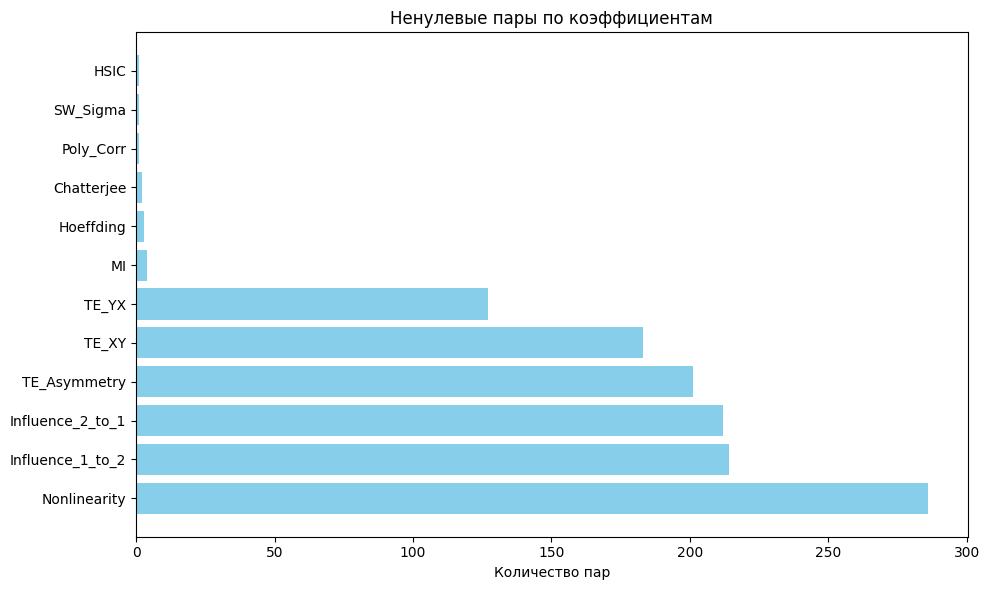

In [148]:
percentile = 50
pairs_above_percentile = []

for i, coeff_name in enumerate(nonlinear_coefs):
    # Вычисляем перцентиль для i-го коэффициента в полном датасете corr
    percentile_ = np.percentile(corr[coeff_name], percentile)
    
    # Находим все пары из only_nonlinear_corr где этот коэффициент > перцентиля
    mask = only_nonlinear_corr[coeff_name] > percentile_
    top_pairs = only_nonlinear_corr[mask][['Asset1', 'Asset2']].values.tolist()
    
    pairs_above_percentile.append(top_pairs)
amount_of_pairs_above_percentile = [len(pairs) for pairs in pairs_above_percentile]
print(pairs_above_percentile)
print(amount_of_pairs_above_percentile)
print(nonlinear_coefs)
print(sum(amount_of_pairs_above_percentile))

mask = np.array(amount_of_pairs_above_percentile) > 0
names = np.array(nonlinear_coefs)[mask]
values = np.array(amount_of_pairs_above_percentile)[mask]

# Сортируем по убыванию
sort_idx = np.argsort(values)[::-1]
names = names[sort_idx]
values = values[sort_idx]

plt.figure(figsize=(10,6))
plt.barh(names, values, color='skyblue')
plt.xlabel('Количество пар')
plt.title('Ненулевые пары по коэффициентам')
plt.tight_layout()
plt.show()


In [256]:
import itertools

unique_pairs = list(set(itertools.chain.from_iterable(
    [tuple(pair) for sublist in pairs_above_percentile if sublist 
     for pair in sublist]
)))

print(len(unique_pairs))
# [('BK', 'NOKUSD=X'), ('NEM', 'EURCHF=X'), ('TJX', 'MYRUSD=X'), ...]


107


In [271]:
nonlinear_coefs[-5]

'Nonlinearity'

In [273]:
coef_for_graph = 'Nonlinearity'
len(pairs_above_percentile[-5])


286

In [275]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

pairs = [['ATO','HKDUSD=X'], ['GOOG','IDRUSD=X'], ['GOOG', 'ILSUSD=X']]

df = clean_data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df['t'] = range(len(df))

i0 = 0
i_mid = len(df) // 2
i1 = len(df) - 1

tickvals = [df.loc[i0, 't'], df.loc[i_mid, 't'], df.loc[i1, 't']]
ticktext = [
    df.loc[i0, 'Date'].strftime('%Y-%m-%d'),
    df.loc[i_mid, 'Date'].strftime('%Y-%m-%d'),
    df.loc[i1, 'Date'].strftime('%Y-%m-%d'),
]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f'{x} vs {y}' for x, y in pairs],
    horizontal_spacing=0.06,   # меньше расстояние между графиками [web:120]
)

for i, (col_x, col_y) in enumerate(pairs, start=1):
    fig.add_trace(
        go.Scatter(
            x=df[col_x],
            y=df[col_y],
            mode='markers',
            marker=dict(
                color=df['t'],
                colorscale='Agsunset',
                reversescale=True,
                size=5,
                opacity=0.8,
                line=dict(width=0),
                showscale=(i == 3),
                colorbar=dict(
                    title='Date',
                    tickmode='array',
                    tickvals=tickvals,
                    ticktext=ticktext,
                    len=0.88,      # длиннее colorbar по высоте, чтобы занять место
                    y=0.5
                ) if i == 3 else None
            ),
            showlegend=False
        ),
        row=1, col=i
    )

fig.update_layout(
    template='plotly_white',
    height=360,  # меньше высота => меньше пустоты сверху/снизу
    margin=dict(l=40, r=20, t=40, b=35),  # поджимаем поля [web:173]
)

# Чуть ближе подписи сабплотов (Plotly делает их аннотациями)
fig.update_annotations(y=1.02)

fig.update_xaxes(title_text=pairs[0][0], row=1, col=1)
fig.update_yaxes(title_text=pairs[0][1], row=1, col=1)
fig.update_xaxes(title_text=pairs[1][0], row=1, col=2)
fig.update_yaxes(title_text=pairs[1][1], row=1, col=2)
fig.update_xaxes(title_text=pairs[2][0], row=1, col=3)
fig.update_yaxes(title_text=pairs[2][1], row=1, col=3)

fig.show()


In [ ]:
import pandas as pd
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# подготовка данных 1 раз (чтобы не делать одно и то же в каждом цикле)
df = clean_data.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["t"] = range(len(df))  # 0..N-1

# подписи colorbar: min / mid / max даты (ровно как договаривались)
i0, i_mid, i1 = 0, len(df)//2, len(df)-1
tickvals = [df.loc[i0, "t"], df.loc[i_mid, "t"], df.loc[i1, "t"]]
ticktext = [
    df.loc[i0, "Date"].strftime("%Y-%m-%d"),
    df.loc[i_mid, "Date"].strftime("%Y-%m-%d"),
    df.loc[i1, "Date"].strftime("%Y-%m-%d"),
]

for coeff_name, pairs in zip(nonlinear_coefs, pairs_above_percentile):
    if not pairs:
        continue

    n = min(3, len(pairs))
    cur_pairs = random.sample(pairs, n)

    fig = make_subplots(
        rows=1, cols=n,
        subplot_titles=[f"{x} vs {y}" for x, y in cur_pairs],
        horizontal_spacing=0.06,  # “чуть больше пространства” [web:120]
    )

    for j, (col_x, col_y) in enumerate(cur_pairs, start=1):
        fig.add_trace(
            go.Scatter(
                x=df[col_x],
                y=df[col_y],
                mode="markers",
                marker=dict(
                    color=df["t"],
                    colorscale="Agsunset",
                    reversescale=True,  # сверху старые даты, снизу поздние [web:59]
                    size=5,
                    opacity=0.85,
                    line=dict(width=0),
                    showscale=(j == n),  # один colorbar справа
                    colorbar=dict(
                        title="Date",
                        tickmode="array",
                        tickvals=tickvals,
                        ticktext=ticktext,
                        len=0.88,
                        y=0.5,
                    ) if j == n else None,
                ),
                showlegend=False,
            ),
            row=1, col=j,
        )

        fig.update_xaxes(title_text=col_x, row=1, col=j)
        fig.update_yaxes(title_text=col_y, row=1, col=j)

    fig.update_layout(
        template="plotly_white",
        title=dict(text=str(coeff_name), x=0.5, xanchor="center"),
        height=380,
        margin=dict(l=45, r=20, t=55, b=45),
    )

    # чуть прижать subplot titles к графикам, чтобы не было лишнего воздуха сверху
    fig.update_annotations(y=1.02)

    fig.show()


## Выявление непарных коинтеграций

In [ ]:
# corr = pd.read_csv('all_analytic_data.csv')

In [49]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries: int,
                       treshold: float = 0.05,
                       max_iter: int = 5):
    d = 0
    while True:
        # Perform ADF test
        adf_test = adfuller(timeseries.dropna())
        p_value = adf_test[1]

        # Check p-value
        if p_value <= treshold:
            # Series is stationary
            break
        else:
            # Series is not stationary
            timeseries = timeseries.diff().dropna()
            d += 1
            if d > max_iter:
                print(f"Warning: Series did not become stationary after {d} differences.")
                break
    return d

stationary_orders = {}
stationary_series = []
series_for_johansen_test = []
for col in clean_data.drop(columns=['Date']).columns:
    order = check_stationarity(clean_data[col])
    stationary_orders[col] = order
    if order == 0:
        stationary_series.append(col)
    elif order == 1: 
        series_for_johansen_test.append(col)
    else:
        print(f"Ряд '{col}' является стационарным после {order} разностей.")

# for col, order in stationary_orders.items():
#     print(f"Ряд '{col}' является стационарным после {order} разностей.")

Стационарные ряды:

In [62]:
print(f"Stationary series: {len(stationary_series)}")
print(stationary_series)

Stationary series: 39
['MGM', 'HST', 'FTV', 'KDP', 'CSGP', 'SYY', 'AEDUSD=X', 'FRT', 'AWK', 'O', 'HON', 'AMCR', 'WAT', 'JKHY', 'JBHT', 'UNP', 'NDSN', 'MTD', 'TXN', 'CSX', 'HSIC', 'VTRS', 'EURGBP=X', 'HPQ', 'SBUX', 'AVY', 'RUBUSD=X', 'FCX', 'F', 'KIM', 'MSCI', 'SARUSD=X', 'BG', 'HOLX', 'PSA', 'DHR', 'KEYS', 'TMO', 'BEN']


In [64]:
print(series_for_johansen_test)

['SBAC', 'OMC', 'CME', 'GNRC', 'ETN', 'JPYUSD=X', 'CMS', 'KWDUSD=X', 'ZARUSD=X', 'ORLY', 'CADUSD=X', 'ESS', 'CCI', 'AKAM', 'IBM', 'LULU', 'BRK-B', 'AMAT', 'META', 'TJX', 'CINF', 'EXE', 'DOC', 'MTCH', 'DXCM', 'GEN', 'CHFUSD=X', 'BKNG', 'GIS', 'NVR', 'ICE', 'AEP', 'PLTR', 'DGX', 'UPS', 'IFF', 'ECL', 'T', 'STE', 'COST', 'K', 'COR', 'BR', 'DASH', 'CDNS', 'STX', 'CHD', 'GDDY', 'SCHW', 'NZDUSD=X', 'SEKUSD=X', 'BRO', 'VMC', 'POOL', 'YUM', 'COIN', 'QCOM', 'DUK', 'TYL', 'FANG', 'EQR', 'TSLA', 'EURJPY=X', 'LII', 'LMT', 'AOS', 'MSI', 'VLO', 'PGR', 'NDAQ', 'CMI', 'ALLE', 'EVRG', 'ROK', 'CBOE', 'UDR', 'FDX', 'IVZ', 'ON', 'BX', 'CPB', 'ALGN', 'DTE', 'HPE', 'AMGN', 'ZBH', 'DKKUSD=X', 'GBPUSD=X', 'ACGL', 'EBAY', 'EL', 'EURUSD=X', 'IRM', 'TTWO', 'HLT', 'PAYC', 'NWS', 'PM', 'WTW', 'CRWD', 'MKTX', 'NFLX', 'LDOS', 'TT', 'SYF', 'LH', 'EQT', 'CBRE', 'ADM', 'MMC', 'CTAS', 'JCI', 'GPN', 'LLY', 'BRLUSD=X', 'TDG', 'XYZ', 'MPC', 'INVH', 'HUFUSD=X', 'TPR', 'UAL', 'ADBE', 'PFE', 'CHTR', 'VZ', 'CNYUSD=X', 'ACN', 'S

In [125]:
clean_data.describe()

SBAC          OMC          CME         GNRC          ETN  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean    249.918079    74.748654   196.712512   201.839856   218.241082   
std      46.763958    11.415995    36.571573   102.362260    87.238148   
min     179.833618    50.690987   142.789597    82.199997   104.904053   
25%     212.195171    66.062756   169.646927   121.662498   142.794273   
50%     236.610954    73.759838   188.026604   155.674995   175.044022   
75%     290.373039    83.746073   208.933506   266.772507   307.448036   
max     365.462097   101.859230   288.007324   505.799988   391.619537   

          JPYUSD=X          CMS     KWDUSD=X     ZARUSD=X         ORLY  ...  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000  ...   
mean      0.007499    58.990171     3.275626     0.059028    61.353287  ...   
std       0.001019     6.999798     0.027092     0.005885    20.588697  ...   
min       0.006188    46.575531     3.223415     0.050570    28.364668  ...   
25%       0.006723    53.861142     3.256268     0.054388    43.684502  ...   
50%       0.007031    56.500149     3.267760     0.056700    60.957668  ...   
75%       0.008649    64.239321     3.293184     0.064668    75.533998  ...   
max       0.009739    75.440002     3.336670     0.074527   107.820000  ...   

               ROL         MRNA         CPAY          EFX         VICI  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean     40.971874   131.746246   267.828623   225.284468    27.029360   
std       8.419005    87.233008    47.831339    35.070978     3.158938   
min      27.521664    22.360001   164.000000   146.783630    19.301397   
25%      34.170364    72.927502   233.569996   195.519886    24.674337   
50%      38.183830   125.715000   265.220001   227.909088    27.268193   
75%      47.884951   162.882496   295.807487   253.256477    29.257365   
max      61.500000   484.470001   389.549988   303.869263    33.461643   

          AUDJPY=X          ALB     IDRUSD=X          BEN         FSLR  
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000  
mean     92.179537   158.143051     0.000066    22.772664   148.905772  
std       6.872221    63.832079     0.000003     2.675129    54.706685  
min      76.731003    50.158821     0.000059    16.207933    61.400002  
25%      85.222498    97.810438     0.000063    20.783390    95.534998  
50%      93.859001   153.411034     0.000065    22.784257   153.020004  
75%      97.014751   212.492176     0.000069    24.665155   191.277504  
max     109.105003   311.628021     0.000072    30.833389   300.709991  

[8 rows x 533 columns]

In [97]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

def run_johansen_test(dataframe, series_names, test_name):
    print(f"--- Тест Йохансена на коинтеграцию для {test_name} ---")
    selected_series_df = dataframe[series_names]
    num_series = len(series_names)

    if num_series < 2:
        print(f"Предупреждение: Для теста Йохансена требуется как минимум 2 ряда. Предоставлено только {num_series} для {test_name}.")
        print("="*80 + "\n")
        return

    # Determine optimal lag order for VAR model
    model = VAR(selected_series_df)
    try:
        # Using maxlags=10 for robustness and to prevent excessive computation
        lag_order_results = model.select_order(maxlags=10)
        optimal_lag = lag_order_results.bic # Using BIC for optimal lag selection
    except ValueError as e:
        print(f"Не удалось определить оптимальный порядок лагов для {test_name} из-за: {e}. Используется порядок лагов по умолчанию: 1.")
        optimal_lag = 1 # Fallback to a default lag if select_order fails
    except Exception as e:
        print(f"Произошла непредвиденная ошибка при определении оптимального порядка лагов для {test_name}: {e}. Используется порядок лагов по умолчанию: 1.")
        optimal_lag = 1

    print(f"Оптимальный порядок лагов (на основе BIC) для {test_name}: {optimal_lag}")

    # For coint_johansen, k_ar_diff is the number of lagged differences,
    # which should be p-1 where p is the order of the VAR model in levels.
    # If optimal_lag (from VAR.select_order()) is p, then k_ar_diff = p-1.
    # In such cases, it's common to set k_ar_diff = 1 (effectively VAR(2) in levels for the test).
    johansen_lags = max(1, optimal_lag - 1)
    print(f"Количество лагированных разностей (k_ar_diff), используемых в тесте Йохансена: {johansen_lags}")

    # Perform Johansen Cointegration Test
    # det_order=0 assumes a constant in the cointegrating relationship.
    result = coint_johansen(selected_series_df.values, det_order=0, k_ar_diff=johansen_lags)

    # print("Собственные значения:", result.eig)

    # headers = ["Статистика теста", "90% Критическое", "95% Критическое", "99% Критическое"]
    # print("\nСтатистика следа и критические значения (H0: r <= k):")
    # print(f"{'Ранг':<5} {'Гипотеза':<10} {headers[0]:<20} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20}")
    # for i in range(num_series):
    #     # result.lr1[i] is the trace statistic for the hypothesis that there are at most i cointegrating relationships.
    #     print(f"{i:<7} r<={i:<10} {result.lr1[i]:<20.3f} {result.cvt[i][0]:<20.3f} {result.cvt[i][1]:<20.3f} {result.cvt[i][2]:<20.3f}")

    # print("\nСтатистика максимального собственного значения и критические значения (H0: r <= k):")
    # print(f"{'Ранг':<5} {'Гипотеза':<10} {headers[0]:<20} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20}")
    # for i in range(num_series):
    #     # result.lr2[i] is the max-eigenvalue statistic for the hypothesis that there are at most i cointegrating relationships.
    #     print(f"{i:<7} r<={i:<10} {result.lr2[i]:<20.3f} {result.cvm[i][0]:<20.3f} {result.cvm[i][1]:<20.3f} {result.cvm[i][2]:<20.3f}")
    # print("\n" + "="*80 + "\n")

    # Determine cointegration rank based on Trace Statistic (95% level)
    rank_trace = 0
    for r in range(num_series):
        if result.lr1[r] > result.cvt[r, 1]:  # Compare with 95% critical value
            rank_trace = r + 1
        else:
            break

    # Determine cointegration rank based on Max-Eigenvalue Statistic (95% level)
    rank_max_eig = 0
    for r in range(num_series):
        if result.lr2[r] > result.cvm[r, 1]:  # Compare with 95% critical value
            rank_max_eig = r + 1
        else:
            break

    final_rank = min(rank_trace, rank_max_eig)
    print(f"Итоговый ранг коинтеграции (консервативный) для {test_name}: {final_rank}")

    if final_rank > 0:
        print(f"\nНайдено {final_rank} коинтегрирующих векторов для {test_name}. Извлекаем их:")
        # The eigenvectors (evec) correspond to the cointegrating vectors
        # They are typically normalized. Each column is a cointegrating vector.
        # The first 'final_rank' eigenvectors (columns) are the cointegrating vectors.
        cointegrating_vectors = result.evec[:, :final_rank]

        print("Коинтегрирующие векторы (нормализованные):")
        for i in range(final_rank):
            print(f"  Вектор {i+1}: {cointegrating_vectors[:, i]}")

        print("\nФормирование стационарных линейных комбинаций (коинтегрирующих отношений):")
        for i in range(final_rank):
            linear_combination_expr = ""
            for j, col_name in enumerate(series_names):
                coeff = cointegrating_vectors[j, i]
                if coeff >= 0:
                    linear_combination_expr += f" + {coeff:.6f}*{col_name}"
                else:
                    linear_combination_expr += f" - {-coeff:.6f}*{col_name}"
            # Remove leading ' + '
            linear_combination_expr = linear_combination_expr.strip().lstrip('+-').strip()
            print(f"  Cointegrating Relationship {i+1}: {linear_combination_expr} ≈ I(0) (стационарный)")
        return cointegrating_vectors
    else:
        print(f"\nКоинтеграция между рядами {test_name} не обнаружена при уровне значимости 95%.")
        return []
     # по столбцам коэффы j-го коинт вектора

# Group 1: ts1, ts2, ts3, ts4 (all I(1) from previous ADF test)
cointegrating_vectors = run_johansen_test(clean_data, series_for_johansen_test[:418] + series_for_johansen_test[420:421] \
                                          + series_for_johansen_test[424:424] + series_for_johansen_test[426:450], "I(1) Ряды: ")

--- Тест Йохансена на коинтеграцию для I(1) Ряды:  ---
Не удалось определить оптимальный порядок лагов для I(1) Ряды:  из-за: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.. Используется порядок лагов по умолчанию: 1.
Оптимальный порядок лагов (на основе BIC) для I(1) Ряды: : 1
Количество лагированных разностей (k_ar_diff), используемых в тесте Йохансена: 1


/tmp/ipykernel_12401/3192028320.py:38: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  result = coint_johansen(selected_series_df.values, det_order=0, k_ar_diff=johansen_lags)


LinAlgError: Matrix is not positive definite

In [ ]:
cointegrating_vectors

Вывод: непарные коинтеграции можно делать только после кластеризации

## Обучение зависимостей

In [169]:
import numpy as np
import pandas as pd

def fit_implicit_polynomial_svd(df, col_x, col_y, degree=7):
    """
    Строит полином F(x, y) = sum_k a_k * x^i_k * y^j_k,
    0 <= i + j <= degree, по точкам (x, y) из df.

    Коэффициенты a берутся как правый сингулярный вектор,
    соответствующий наименьшему сингулярному числу матрицы мономов M
    (M @ a ≈ 0, ||a|| = 1).

    Возвращает:
      F(df_new) -> np.ndarray значений F(x, y) для строк df_new.
    """
    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()
    n = x.shape[0]

    # 1. все пары степеней (i, j), 0 <= i + j <= degree
    exponents = []
    for total_deg in range(degree + 1):
        for i in range(total_deg + 1):
            j = total_deg - i
            exponents.append((i, j))
    exponents = np.array(exponents, dtype=int)
    m = exponents.shape[0]

    # 2. матрица мономов M
    M = np.empty((n, m), dtype=float)
    for k, (i, j) in enumerate(exponents):
        M[:, k] = (x ** i) * (y ** j)

    # 3. SVD и правый сингулярный вектор при минимальном σ
    # M = U Σ V^T, последний столбец V (или последняя строка V^T) — искомый a
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    a = Vt[-1, :]      # shape (m,), уже нормирован: ||a|| = 1

    # 4. возвращаем функцию F(df_new)
    def F(df_new: pd.DataFrame) -> np.ndarray:
        x_new = df_new[col_x].to_numpy()
        y_new = df_new[col_y].to_numpy()
        n_new = x_new.shape[0]
        M_new = np.empty((n_new, m), dtype=float)
        for k, (i, j) in enumerate(exponents):
            M_new[:, k] = (x_new ** i) * (y_new ** j)
        return M_new @ a

    return F


#### Тест на окружности

In [176]:
n_points = 1000
angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
x = np.cos(angles)
y = np.sin(angles)

# можно добавить небольшой шум
noise_level = 0.1
x_noisy = x + noise_level * np.random.randn(n_points)
y_noisy = y + noise_level * np.random.randn(n_points)

test_data = pd.DataFrame({
    'x': x_noisy,
    'y': y_noisy
})

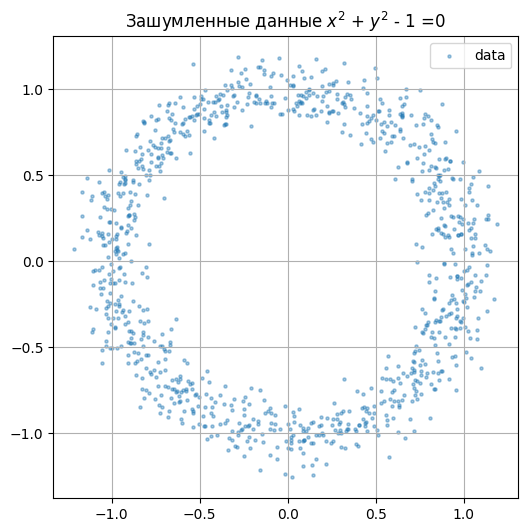

In [179]:
plt.figure(figsize=(6, 6))
plt.scatter(test_data['x'], test_data['y'], s=5, alpha=0.4, label='data')
plt.title(r'Зашумленные данные $x^2$ + $y^2$ - 1 =0')
plt.legend()
plt.grid(True)
plt.show()

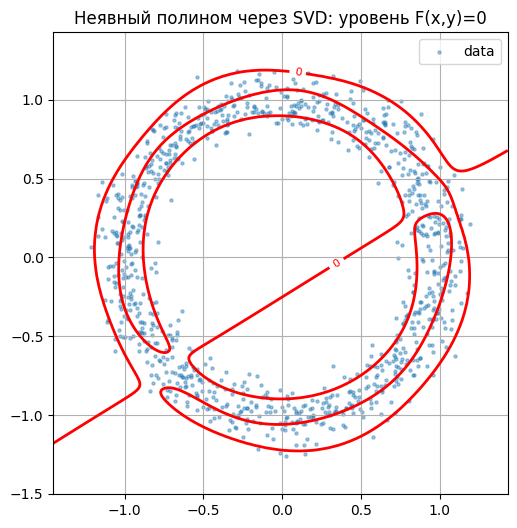

In [185]:
# test_data: синтетический круг, как мы генерировали раньше
F_circle = fit_implicit_polynomial_svd(test_data, 'x', 'y', degree=7)

# построение уровня F(x,y)=0
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(test_data['x'], test_data['y'], s=5, alpha=0.4, label='data')

num_points = 200
x_min, x_max = test_data['x'].min(), test_data['x'].max()
y_min, y_max = test_data['y'].min(), test_data['y'].max()
pad_x = 0.1 * (x_max - x_min)
pad_y = 0.1 * (y_max - y_min)
x_min, x_max = x_min - pad_x, x_max + pad_x
y_min, y_max = y_min - pad_y, y_max + pad_y

xs = np.linspace(x_min, x_max, num_points)
ys = np.linspace(y_min, y_max, num_points)
X, Y = np.meshgrid(xs, ys)

grid_df = pd.DataFrame({'x': X.ravel(), 'y': Y.ravel()})
Z = F_circle(grid_df).reshape(X.shape)

cs = plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.clabel(cs, inline=True, fontsize=8)
plt.gca().set_aspect('equal', 'box')
plt.title('Неявный полином через SVD: уровень F(x,y)=0')
plt.legend()
plt.grid(True)
plt.show()


#### Обучение всех функций

In [203]:
import numpy as np

def mse(a: np.ndarray) -> float:
    return float(np.mean(a ** 2))

def build_exponents(max_degree):
    exponents = []
    for total_deg in range(max_degree + 1):
        for i in range(total_deg + 1):
            j = total_deg - i
            exponents.append((i, j))
    return np.array(exponents, dtype=int)

def format_coeff(c, sig=2):
    """
    Округление коэффициента до двух значащих цифр и приведение к строке.
    """
    if c == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(c))))
    factor = 10 ** (exp - sig + 1)
    rounded = round(c / factor) * factor
    # убираем лишние нули
    s = f"{rounded:.6g}"
    return s

def polynomial_to_string(a, exponents, x_name="x", y_name="y", sig=2):
    """
    Строка вида: <два старших монома> + ... + <константа>.
    Если мономов меньше, выводим сколько есть.
    """
    # собираем все мономы с их степенью (i+j)
    raw_terms = []
    for coef, (i, j) in zip(a, exponents):
        if np.isclose(coef, 0.0):
            continue
        deg = i + j
        coef_str = format_coeff(coef, sig=sig)
        sign = "-" if float(coef_str) < 0 else "+"
        coef_abs_str = coef_str.lstrip("+-")

        monom_parts = []
        if not np.isclose(float(coef_abs_str), 1.0) or (i == 0 and j == 0):
            monom_parts.append(coef_abs_str)
        if i > 0:
            monom_parts.append(f"{x_name}" + (f"^{i}" if i > 1 else ""))
        if j > 0:
            monom_parts.append(f"{y_name}" + (f"^{j}" if j > 1 else ""))

        term = "*".join(monom_parts) if monom_parts else "0"
        raw_terms.append((deg, sign, term))

    if not raw_terms:
        return "0"

    # сортируем по степени по убыванию (старшие мономы первыми)
    raw_terms.sort(key=lambda t: t[0], reverse=True)

    # выделяем константу (deg == 0) и старшие мономы (deg > 0)
    const_terms = [t for t in raw_terms if t[0] == 0]
    high_terms = [t for t in raw_terms if t[0] > 0]

    pieces = []

    # берём до двух старших мономов
    if high_terms:
        top_two = high_terms[:2]

        # первый моном: без ведущего "+" при положительном знаке
        first_sign, first_term = top_two[0][1], top_two[0][2]
        if first_sign == "-":
            pieces.append("- " + first_term)
        else:
            pieces.append(first_term)

        # второй моном (если есть) с явным знаком
        if len(top_two) > 1:
            sign2, term2 = top_two[1][1], top_two[1][2]
            pieces.append(f" {sign2} {term2}")

        # если есть ещё мономы помимо этих двух и константы, ставим " + ..."
        if len(high_terms) > 2 or len(const_terms) > 0:
            pieces.append(" + ...")
    else:
        # нет старших мономов, остаётся только константа
        # обработаем её ниже как обычную константу
        pass

    # добавляем константу (если есть)
    if const_terms:
        # берём первую константу (их может быть максимум одна при корректном наборе мономов)
        _, const_sign, const_term = const_terms[0]
        if not pieces:
            # если кроме константы ничего нет
            if const_sign == "-":
                pieces.append("- " + const_term)
            else:
                pieces.append(const_term)
        else:
            pieces.append(f" {const_sign} {const_term}")

    return "".join(pieces)


def fit_best_implicit_for_pair_with_name(df, col_x, col_y, max_degree=7):
    """
    Возвращает:
      F_best(df_new) и строку-формулу полинома.
    """
    best_F = None
    best_mse = np.inf
    best_name = None
    best_a = None
    best_exponents = None

    for deg in range(max_degree + 1):
        # учим полином через SVD
        F_candidate, a_candidate, exponents = fit_implicit_polynomial_svd_return_params(
            df, col_x, col_y, degree=deg
        )
        values = F_candidate(df)
        cur_mse = mse(values)

        if cur_mse < best_mse:
            best_mse = cur_mse
            best_F = F_candidate
            best_a = a_candidate
            best_exponents = exponents

    # строковое имя полинома
    best_name = polynomial_to_string(best_a, best_exponents, x_name='X', y_name='Y', sig=2)
    return best_F, best_name

# модифицированный SVD-фиттер, который ещё возвращает коэффициенты и степени
def fit_implicit_polynomial_svd_return_params(df, col_x, col_y, degree=7):
    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()
    n = x.shape[0]

    exponents = build_exponents(degree)
    m = exponents.shape[0]

    M = np.empty((n, m), dtype=float)
    for k, (i, j) in enumerate(exponents):
        M[:, k] = (x ** i) * (y ** j)

    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    a = Vt[-1, :]  # коэффициенты полинома (||a||=1)

    def F(df_new):
        x_new = df_new[col_x].to_numpy()
        y_new = df_new[col_y].to_numpy()
        n_new = x_new.shape[0]
        M_new = np.empty((n_new, m), dtype=float)
        for k, (i, j) in enumerate(exponents):
            M_new[:, k] = (x_new ** i) * (y_new ** j)
        return M_new @ a

    return F, a, exponents

# ---- основной цикл по массиву pairs_above_percentile ----

all_functions = []      # список списков функций
all_function_names = [] # список списков строк-формул
max_degree = 7          # максимальная степень многочлена

for idx, pairs_for_idx in enumerate(pairs_above_percentile):
    functions_for_idx = []
    names_for_idx = []

    if pairs_for_idx:
        for ticker_x, ticker_y in pairs_for_idx:
            F_best, name_best = fit_best_implicit_for_pair_with_name(
                clean_data[:len(clean_data) // 2], # Обучаем формулу на первой половине датасета
                col_x=ticker_x,
                col_y=ticker_y,
                max_degree=max_degree
            )
            functions_for_idx.append(F_best)
            names_for_idx.append(name_best)

    all_functions.append(functions_for_idx)
    all_function_names.append(names_for_idx)


In [204]:
all_function_names

[[],
 [],
 [],
 ['0.91*Y^5 - 0.0021*X*Y^4 + ... - 3.6e-06',
  '0.068*Y^5 - 0.00044*X*Y^4 + ... - 0.055',
  '0.68*Y^4 + 0.00088*X*Y^3 + ... + 0.0032',
  '- 0.68*Y^4 - 0.001*X*Y^3 + ... - 0.0028'],
 ['- 0.8*Y^5 + 0.012*X*Y^4 + ... + 0.00012',
  '- 1.4e-07*Y^4 - 1.6e-07*X*Y^3 + ... - 1'],
 ['- 0.8*Y^5 + 0.012*X*Y^4 + ... + 0.00012',
  '- 0.68*Y^4 - 0.001*X*Y^3 + ... - 0.0028',
  '- 1.4e-07*Y^4 - 1.6e-07*X*Y^3 + ... - 1'],
 ['- 3.3e-08*X^4 + 3e-08*Y^3 + ... - 1'],
 [],
 ['- 0.8*Y^5 + 0.012*X*Y^4 + ... + 0.00012'],
 ['- 3.3e-08*X^4 + 3e-08*Y^3 + ... - 1'],
 [],
 [],
 ['0.039*Y^4 + 0.00074*X*Y^3 + ... + 0.28',
  '0.98*Y^5 - 0.0008*X*Y^4 + ... - 6e-08',
  '- 0.18*Y^5 + 0.0014*X*Y^4 + ... + 0.016',
  '0.89*Y^4 + 3.5e-06*X*Y^3 + ... + 0.00024',
  '1.7e-07*Y^4 + 1.2e-07*X*Y^3 + ... + 1',
  '0.91*Y^5 + 0.00063*X*Y^4 + ... + 1.2e-05',
  '3e-08*Y^4 + 1.1e-07*X*Y^3 + ... + 1',
  '- 0.55*Y^5 - 0.0022*X*Y^4 + ... + 0.00073',
  '0.59*Y^5 + 0.002*X*Y^4 + ... - 0.00043',
  '- 0.65*Y^5 + 0.0032*X*Y^4 + ..

In [286]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ----------- что рисуем -----------
pairs = [['ATO','HKDUSD=X'], ['GOOG','IDRUSD=X'], ['GOOG', 'ILSUSD=X']]

# ----------- 1) подготовка данных / цвета -----------
df = clean_data.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["t"] = range(len(df))

half = len(df) // 2

# подписи colorbar: 1я точка, четверть датасета, половина датасета (т.к. показываем только половину)
i0 = 0
i_quarter = half // 2
i_half = half - 1

tickvals = [df.loc[i0, "t"], df.loc[i_quarter, "t"], df.loc[i_half, "t"]]
ticktext = [
    df.loc[i0, "Date"].strftime("%Y-%m-%d"),
    df.loc[i_quarter, "Date"].strftime("%Y-%m-%d"),
    df.loc[i_half, "Date"].strftime("%Y-%m-%d"),
]

# ----------- 2) достаём функции F из all_functions по соответствующим парам -----------
# строим мэппинг "пара -> функция"
pair_to_F = {}
for pairs_list, funcs_list in zip(pairs_above_percentile, all_functions):
    if not pairs_list:
        continue
    for (col_x, col_y), F in zip(pairs_list, funcs_list):
        pair_to_F[(col_x, col_y)] = F

# проверка что все нужные пары найдены
missing = [p for p in pairs if tuple(p) not in pair_to_F]
if missing:
    raise KeyError(f"Не найдены функции для пар: {missing}. Проверь, что пары есть в pairs_above_percentile.")

Fs = [pair_to_F[tuple(p)] for p in pairs]

# ----------- 3) рисуем 3 сабплота -----------
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f"{x} vs {y}" for x, y in pairs],
    horizontal_spacing=0.06,
)

for i, ((col_x, col_y), F) in enumerate(zip(pairs, Fs), start=1):
    x = df[col_x].iloc[:half]
    y = df[col_y].iloc[:half]
    t = df["t"].iloc[:half]

    # scatter (Agsunset + градиент по времени, сверху старые, снизу поздние)
    fig.add_trace(
        go.Scatter(
            x=x, y=y,
            mode="markers",
            marker=dict(
                size=5,
                opacity=0.85,
                color=t,
                colorscale="Agsunset",
                reversescale=True,
                line=dict(width=0),
                showscale=(i == 3),
                colorbar=dict(
                    title="Date",
                    tickmode="array",
                    tickvals=tickvals,
                    ticktext=ticktext,
                    len=0.88,
                    y=0.5,
                ) if i == 3 else None,
            ),
            showlegend=False,
        ),
        row=1, col=i
    )

    # изолиния F(x,y)=0 (тёмно-синий)
    num_points = 220
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    pad_x = 0.05 * (x_max - x_min) if x_max > x_min else 1.0
    pad_y = 0.05 * (y_max - y_min) if y_max > y_min else 1.0

    xs = np.linspace(x_min - pad_x, x_max + pad_x, num_points)
    ys = np.linspace(y_min - pad_y, y_max + pad_y, num_points)
    X, Y = np.meshgrid(xs, ys)

    grid_df = pd.DataFrame({col_x: X.ravel(), col_y: Y.ravel()})
    Z = np.asarray(F(grid_df)).reshape(X.shape)

    fig.add_trace(
        go.Contour(
            x=xs, y=ys, z=Z,
            contours=dict(start=0, end=0, size=1, coloring="none", showlines=True),
            line=dict(color="#0B1F5E", width=2.2),
            showscale=False,
            hoverinfo="skip",
            showlegend=False,
        ),
        row=1, col=i
    )

    fig.update_xaxes(title_text=col_x, row=1, col=i)
    fig.update_yaxes(title_text=col_y, row=1, col=i)

fig.update_layout(
    template="plotly_white",
    height=360,
    margin=dict(l=40, r=20, t=40, b=35),
    showlegend=False
)
fig.update_annotations(y=1.02)

fig.show()


In [ ]:
import random
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1) нумерация точек во времени
df = clean_data.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["t"] = range(len(df))  # 0..N-1

half = len(df) // 2

# 2) подписи colorbar, согласованные с отображаемыми данными:
#    первая, четверть (то есть середина первой половины), и последняя из первой половины
i0 = 0
i_quarter = half // 2
i_half = half - 1

tickvals = [df.loc[i0, "t"], df.loc[i_quarter, "t"], df.loc[i_half, "t"]]
ticktext = [
    df.loc[i0, "Date"].strftime("%Y-%m-%d"),
    df.loc[i_quarter, "Date"].strftime("%Y-%m-%d"),
    df.loc[i_half, "Date"].strftime("%Y-%m-%d"),
]

for coeff_name, pairs, funcs in zip(nonlinear_coefs, pairs_above_percentile, all_functions):
    if not pairs:
        continue
    seed = 42
    n = min(3, len(pairs))
    rng = random.Random(seed)
    idxs = rng.sample(range(len(pairs)), n)
    cur_pairs = [pairs[i] for i in idxs]
    cur_funcs = [funcs[i] for i in idxs]

    fig = make_subplots(
        rows=1, cols=n,
        subplot_titles=[f"{x} vs {y}" for x, y in cur_pairs],
        horizontal_spacing=0.06,
    )

    for j, ((col_x, col_y), F) in enumerate(zip(cur_pairs, cur_funcs), start=1):
        x = df[col_x].iloc[:half]
        y = df[col_y].iloc[:half]
        t = df["t"].iloc[:half]

        # scatter с градиентом Agsunset по t
        fig.add_trace(
            go.Scatter(
                x=x, y=y,
                mode="markers",
                marker=dict(
                    size=5,
                    opacity=0.85,
                    color=t,
                    colorscale="Agsunset",
                    reversescale=True,          # сверху старые, снизу поздние
                    showscale=(j == n),         # один colorbar справа
                    colorbar=dict(
                        title="Date",
                        tickmode="array",
                        tickvals=tickvals,
                        ticktext=ticktext,
                        len=0.88,
                        y=0.5,
                    ) if j == n else None,
                ),
                showlegend=False,
            ),
            row=1, col=j
        )

        # изолиния F(x,y)=0 тёмно-синим
        num_points = 220
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        pad_x = 0.05 * (x_max - x_min)
        pad_y = 0.05 * (y_max - y_min)
        xs = np.linspace(x_min - pad_x, x_max + pad_x, num_points)
        ys = np.linspace(y_min - pad_y, y_max + pad_y, num_points)
        X, Y = np.meshgrid(xs, ys)

        grid_df = pd.DataFrame({col_x: X.ravel(), col_y: Y.ravel()})
        Z = np.asarray(F(grid_df)).reshape(X.shape)

        fig.add_trace(
            go.Contour(
                x=xs, y=ys, z=Z,
                contours=dict(start=0, end=0, size=1, coloring="none", showlines=True),
                line=dict(color="#0B1F5E", width=2.2),
                showscale=False,
                hoverinfo="skip",
                showlegend=False,
            ),
            row=1, col=j
        )

        fig.update_xaxes(title_text=col_x, row=1, col=j)
        fig.update_yaxes(title_text=col_y, row=1, col=j)

    fig.update_layout(
        template="plotly_white",
        title=dict(text=str(coeff_name), x=0.5, xanchor="center"),
        height=380,
        margin=dict(l=45, r=20, t=55, b=45),
        showlegend=False,  # убирает trace-надписи
    )
    fig.update_annotations(y=1.02)

    fig.show()


## Бэктест всех комбинаций

In [234]:
def backtest_mean_reversion(clean_data, f, train_length, cut_threshold=2, initial_capital=100, bankruptcy_threshold=0.1, plot_portfolio=False):
    # Создаём колонку f(clean_data)
    clean_data = clean_data.copy()
    clean_data['f_value'] = f(clean_data)
    
    # Инициализация переменных
    portfolio = [initial_capital]
    signals = [0]  # сигналы: 1 (long), -1 (short), 0 (no position)
    returns = clean_data['f_value'].diff().fillna(0)  # доходность функции
    
    for i in range(1, len(clean_data)):
        # Определяем окно для расчёта параметров
        start_idx = max(0, i - train_length)
        window = clean_data['f_value'][start_idx:i]
        mean = window.mean()
        std = window.std()
        
        # Расчёт z-оценки
        z = (clean_data['f_value'].iloc[i] - mean) / std
        
        # Определяем сигнал
        if z > cut_threshold:
            signal = -1  # short
        elif z < -cut_threshold:
            signal = 1   # long
        else:
            signal = 0   # no position
        
        # Обновляем портфель
        portfolio_value = portfolio[-1] + signals[-1] * returns.iloc[i]
        portfolio.append(portfolio_value)
        signals.append(signal)
        
        # Проверка банкротства
        if portfolio_value <= initial_capital * bankruptcy_threshold:
            print(f"Банкротство стратегии: портфель упал до {portfolio_value:.2f}")
            raise Exception(f"Стратегия обанкротилась. Финальная стоимость портфеля: {portfolio_value:.2f}")
    
    # Построение графика портфеля
    if plot_portfolio:
        dates = pd.to_datetime(clean_data['Date'])

        plt.figure(figsize=(12, 6))
        plt.plot(dates, portfolio, label='Портфель')
        plt.axhline(y=initial_capital, color='r', linestyle='--', label='Начальный портфель')
        plt.xlabel('Дата')
        plt.ylabel('Стоимость портфеля')
        plt.title('Динамика стоимости портфеля')
        plt.legend()

        # выбираем 7 индексов по всей длине
        n_ticks = 7
        idxs = np.linspace(0, len(dates) - 1, n_ticks, dtype=int)

        tick_locs = dates.iloc[idxs]
        plt.xticks(tick_locs, rotation=45)

        plt.tight_layout()
        plt.show()
    
    return portfolio


In [235]:
idxs

[76, 151, 53]

In [ ]:
import plotly.graph_objects as go

f1 = {'function': lambda df: df['MGM'] + 2 * df['HST'],
      'formula': 'MGM + 2 * HST'}
f2 = {'function': lambda df: df['MGM'] + 2 * df['HST'],
      'formula': 'MGM + 2 * HST'}

functions_list = [f1, f2]

initial_wealth = 100
print(f"Starting from wealth = {initial_wealth}")

for func_dict in functions_list:
    portfolio = backtest_mean_reversion(
        clean_data=clean_data[len(clean_data)//2:],
        f=func_dict['function'],
        train_length=60,
        cut_threshold=3,
        initial_capital=initial_wealth,
        bankruptcy_threshold=0.1,
        plot_portfolio=False   # выключаем внутренний matplotlib-плот [web:131]
    )

    # x-ось: шаги (если у тебя есть даты внутри backtest — скажи, заменим на Date)
    x = list(range(len(portfolio)))

    fig = go.Figure()

    # основная линия (портфель) — синяя, сплошная
    fig.add_trace(go.Scatter(
        x=x, y=portfolio,
        mode="lines",
        name="Portfolio",
        line=dict(color="#0B1F5E", width=3, dash="solid")  # [web:117]
    ))

    # розовая пунктирная линия — baseline initial wealth
    fig.add_trace(go.Scatter(
        x=[x[0], x[-1]],
        y=[initial_wealth, initial_wealth],
        mode="lines",
        name="Initial wealth",
        line=dict(color="#E457A1", width=2, dash="dash")   # [web:117]
    ))

    fig.update_layout(
        template="plotly_white",
        title=dict(text=f"Mean reversion: {func_dict['formula']}", x=0.5, xanchor="center"),
        height=600,
        width=800,
        margin=dict(l=45, r=20, t=55, b=45),
        xaxis=dict(title="Step"),
        yaxis=dict(title="Wealth"),
        showlegend=False
    )

    fig.show()
    print(f"Strategy {func_dict['formula']} earned: {portfolio[-1]}")


Starting from wealth = 100


Strategy MGM + 2 * HST earned: 107.82819175720215


Strategy MGM + 2 * HST earned: 107.82819175720215


Starting from wealth = 100


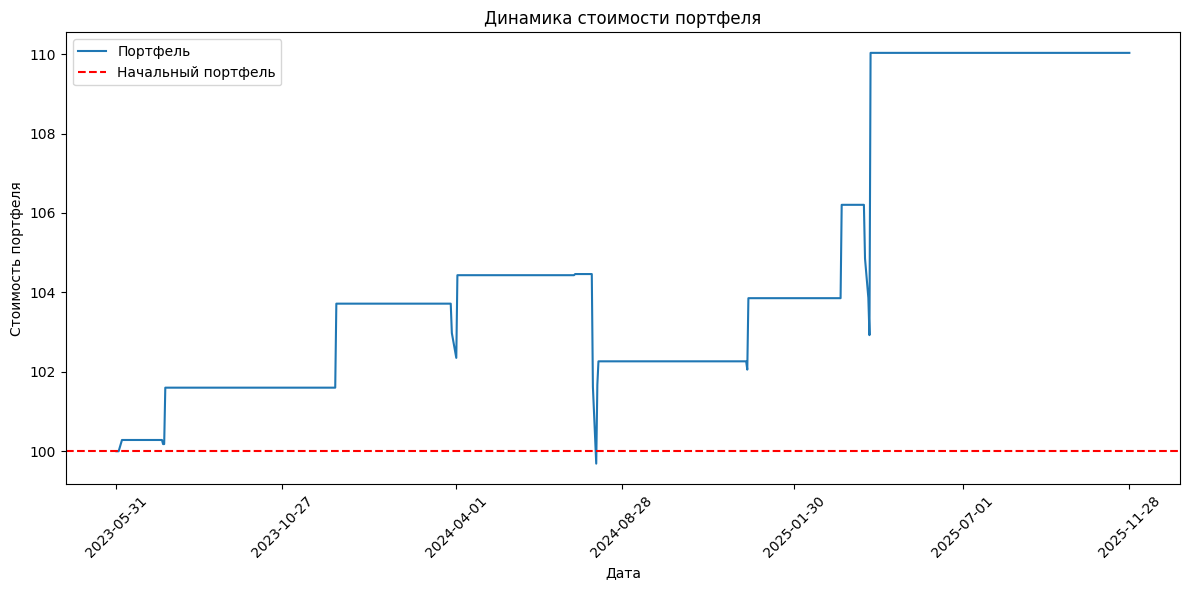

Strategy MGM + 2 * HST earned: 110.03036880493164


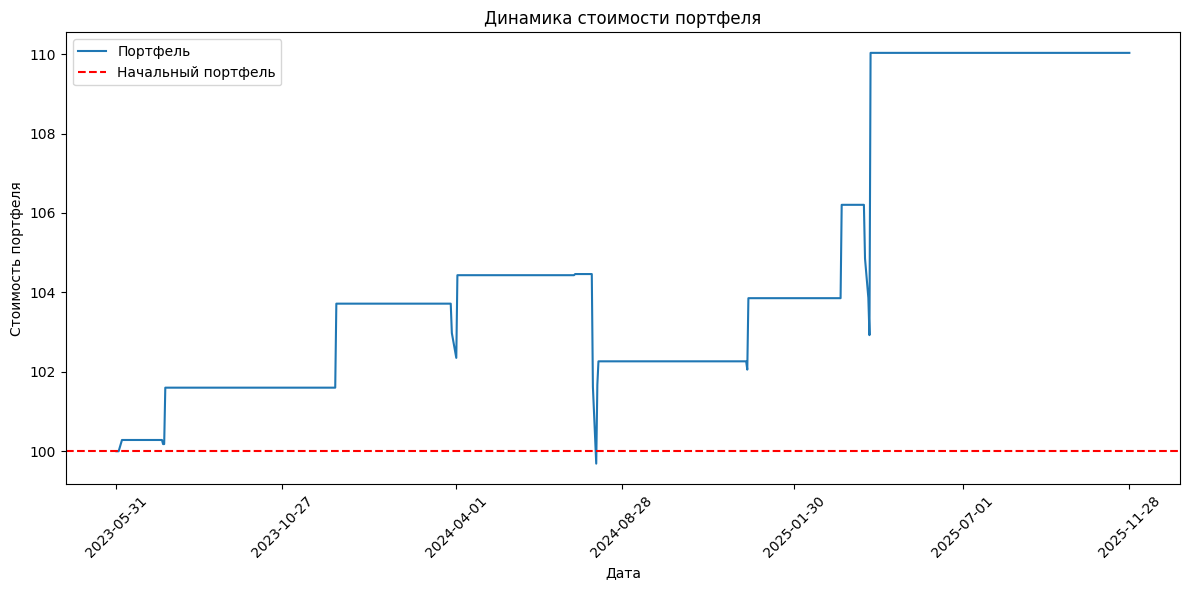

Strategy MGM + 2 * HST earned: 110.03036880493164


In [236]:
f1 = {'function': lambda df: df['MGM'] + 2 * df['HST'], 
      'formula': 'MGM + 2 * HST'}
f2 = {'function': lambda df: df['MGM'] + 2 * df['HST'], 
      'formula': 'MGM + 2 * HST'}
                  
functions_list = [f1, f2]
initial_wealth = 100
print(f"Starting from wealth = {initial_wealth}")
# Запускаем бэктест
for func_dict in functions_list:

    portfolio = backtest_mean_reversion(
        clean_data=clean_data[len(clean_data) // 2:],
        f=func_dict['function'],
        train_length=60,
        cut_threshold=3,
        initial_capital=initial_wealth,
        bankruptcy_threshold=0.1,
        plot_portfolio=True
    )
    print(f"Strategy {func_dict['formula']} earned: {portfolio[-1]}")



In [216]:
import pandas as pd
import numpy as np

# предполагаем:
# - nonlinear_coefs         : список коэффициентов / имён (L штук)
# - pairs_above_percentile  : список длины L, каждый элемент — список пар тикеров
# - all_functions           : список длины L, каждый элемент — список функций F(df)
# - all_function_names      : список длины L, каждый элемент — список строк-формул
# - backtest_mean_reversion : функция из вопроса
# - clean_data              : DataFrame с колонкой 'Date'

results = []  # сюда будем собирать строки для финального датафрейма

train_length = 100        # пример, подставь своё
cut_threshold = 3
initial_capital = 100
bankruptcy_threshold = 0.1 # 10% изначального капитала - банкротство
backtest_start = len(clean_data) // 2 + 1

for coef_name, pairs, funcs, names in zip(
    nonlinear_coefs, pairs_above_percentile, all_functions, all_function_names
):
    if not pairs:
        continue

    for (col_x, col_y), f, poly_name in zip(pairs, funcs, names):
        try:
            portfolio = backtest_mean_reversion(
                clean_data=clean_data[backtest_start:],
                f=f,
                train_length=train_length,
                cut_threshold=cut_threshold,
                initial_capital=initial_capital,
                bankruptcy_threshold=bankruptcy_threshold,
                plot_portfolio=False
            )
            final_pnl = portfolio[-1] #- initial_capital
        except Exception as e:
            # если стратегия обанкротилась или другая ошибка — пишем NaN
            final_pnl = np.nan

        results.append({
            "coef": coef_name,
            "asset_1": col_x,
            "asset_2": col_y,
            "polynomial": poly_name,
            "pnl": final_pnl
        })

backtest_df = pd.DataFrame(results)


Банкротство стратегии: портфель упал до -358.75
Банкротство стратегии: портфель упал до -358.75
Банкротство стратегии: портфель упал до -66.47
Банкротство стратегии: портфель упал до -47.27
Банкротство стратегии: портфель упал до -358.75
Банкротство стратегии: портфель упал до -358.75
Банкротство стратегии: портфель упал до -66.47
Банкротство стратегии: портфель упал до -358.75
Банкротство стратегии: портфель упал до -66.47


In [238]:
# "расплавляем" таблицу корреляций в длинный формат:
corr_long = only_nonlinear_corr.melt(
    id_vars=['Asset1', 'Asset2'],
    var_name='coef',          # имя коэффициента (Pearson, Nonlinearity, TE_XY, ...)
    value_name='corr_value'   # само значение корреляции
)

# приводим имена активов к формату backtest_df
corr_long = corr_long.rename(columns={
    'Asset1': 'asset_1',
    'Asset2': 'asset_2'
})

# джойним к backtest_df по (coef, asset_1, asset_2)
backtest_with_corr = backtest_df.merge(
    corr_long,
    on=['coef', 'asset_1', 'asset_2'],
    how='left'
)

# теперь в backtest_with_corr есть колонка 'corr_value'


In [242]:
backtest_with_corr.sort_values('pnl', ascending=False).head(31)

coef asset_1 asset_2  \
397       Nonlinearity    PLTR     MRK   
1077  Influence_2_to_1    PLTR     MRK   
231              TE_YX    PLTR     MRK   
864   Influence_1_to_2    PLTR     MRK   
791       TE_Asymmetry    PLTR     HSY   
1005  Influence_1_to_2    PLTR     HSY   
1216  Influence_2_to_1    PLTR     HSY   
581       Nonlinearity    PLTR     HSY   
32               TE_XY    PLTR     CHD   
831   Influence_1_to_2    PLTR     CHD   
1045  Influence_2_to_1    PLTR     CHD   
628       TE_Asymmetry    PLTR     CHD   
352       Nonlinearity    PLTR     CHD   
213              TE_YX     STX      ED   
632       TE_Asymmetry     STX      ED   
35               TE_XY     STX      ED   
836   Influence_1_to_2     STX      ED   
1050  Influence_2_to_1     STX      ED   
357       Nonlinearity     STX      ED   
827   Influence_1_to_2    PLTR     PEP   
208              TE_YX    PLTR     PEP   
28               TE_XY    PLTR     PEP   
347       Nonlinearity    PLTR     PEP   
1041  Influence_2_to_1    PLTR     PEP   
644       TE_Asymmetry     TKO     HSY   
849   Influence_1_to_2     TKO     HSY   
376       Nonlinearity     TKO     HSY   
1063  Influence_2_to_1     TKO     HSY   
854   Influence_1_to_2    PLTR     BMY   
384       Nonlinearity    PLTR     BMY   
1067  Influence_2_to_1    PLTR     BMY   

                                       polynomial         pnl  corr_value  
397         4.3e-08*Y^4 + 2.9e-07*X*Y^3 + ... + 1  201.383863    0.019240  
1077        4.3e-08*Y^4 + 2.9e-07*X*Y^3 + ... + 1  201.383863    0.266717  
231         4.3e-08*Y^4 + 2.9e-07*X*Y^3 + ... + 1  201.383863    0.052742  
864         4.3e-08*Y^4 + 2.9e-07*X*Y^3 + ... + 1  201.383863    0.239201  
791     - 2e-08*X*Y^3 - 1.2e-07*X^2*Y^2 + ... - 1  131.107987    0.016905  
1005    - 2e-08*X*Y^3 - 1.2e-07*X^2*Y^2 + ... - 1  131.107987    0.283266  
1216    - 2e-08*X*Y^3 - 1.2e-07*X^2*Y^2 + ... - 1  131.107987    0.298382  
581     - 2e-08*X*Y^3 - 1.2e-07*X^2*Y^2 + ... - 1  131.107987    0.005793  
32          1.2e-08*X^3*Y^2 - 1e-07*Y^4 + ... - 1  127.635083    0.063363  
831         1.2e-08*X^3*Y^2 - 1e-07*Y^4 + ... - 1  127.635083    0.445246  
1045        1.2e-08*X^3*Y^2 - 1e-07*Y^4 + ... - 1  127.635083    0.390393  
628         1.2e-08*X^3*Y^2 - 1e-07*Y^4 + ... - 1  127.635083    0.016169  
352         1.2e-08*X^3*Y^2 - 1e-07*Y^4 + ... - 1  127.635083    0.005958  
213     1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.066995  
632     1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.021512  
35      1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.088507  
836     1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.522414  
1050    1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.545454  
357     1.3e-07*X*Y^3 + 1.9e-07*X^2*Y^2 + ... + 1  113.939185    0.053424  
827   - 3.9e-08*X*Y^3 - 1.1e-07*X^2*Y^2 + ... - 1  108.792796    0.270631  
208   - 3.9e-08*X*Y^3 - 1.1e-07*X^2*Y^2 + ... - 1  108.792796    0.051596  
28    - 3.9e-08*X*Y^3 - 1.1e-07*X^2*Y^2 + ... - 1  108.792796    0.051401  
347   - 3.9e-08*X*Y^3 - 1.1e-07*X^2*Y^2 + ... - 1  108.792796    0.020879  
1041  - 3.9e-08*X*Y^3 - 1.1e-07*X^2*Y^2 + ... - 1  108.792796    0.315404  
644   - 6.8e-08*X^2*Y^2 + 1.4e-07*X^3*Y + ... + 1  106.918447    0.015676  
849   - 6.8e-08*X^2*Y^2 + 1.4e-07*X^3*Y + ... + 1  106.918447    0.283222  
376   - 6.8e-08*X^2*Y^2 + 1.4e-07*X^3*Y + ... + 1  106.918447    0.024263  
1063  - 6.8e-08*X^2*Y^2 + 1.4e-07*X^3*Y + ... + 1  106.918447    0.383951  
854       - 2.2e-07*Y^4 - 6.5e-07*X*Y^3 + ... - 1  101.441470    0.359041  
384       - 2.2e-07*Y^4 - 6.5e-07*X*Y^3 + ... - 1  101.441470    0.032706  
1067      - 2.2e-07*Y^4 - 6.5e-07*X*Y^3 + ... - 1  101.441470    0.329200

In [293]:
coef_pnl = (
    backtest_with_corr
    .groupby("coef", as_index=False)["pnl"]
    .agg(mean_pnl="mean", max_pnl="max")   # pandas mean/max пропускают NaN
    .sort_values("mean_pnl", ascending=False)
)

display(coef_pnl)

coef    mean_pnl     max_pnl
4   Influence_2_to_1  100.869168  201.383863
11             TE_YX  100.867382  201.383863
3   Influence_1_to_2  100.867236  201.383863
6       Nonlinearity  100.598896  201.383863
9       TE_Asymmetry  100.381718  131.107987
10             TE_XY  100.253233  127.635083
0         Chatterjee  100.048921  100.097843
2          Hoeffding  100.032625  100.097843
1               HSIC  100.000022  100.000022
7          Poly_Corr  100.000022  100.000022
5                 MI  100.000010  100.000033
8           SW_Sigma  100.000000  100.000000

In [297]:
coefs_to_plot = ["Nonlinearity", "Influence_1_to_2"]  # (опечатка у тебя была Ifluence...) 

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f"{c}: pnl vs corr_value" for c in coefs_to_plot],
    horizontal_spacing=0.10
)

for i, c in enumerate(coefs_to_plot, start=1):
    d = backtest_with_corr.loc[
        (backtest_with_corr["coef"] == c) &
        (backtest_with_corr["pnl"].notna()) &
        (backtest_with_corr["corr_value"].notna()),
        ["corr_value", "pnl"]
    ].copy()

    fig.add_trace(
        go.Scatter(
            x=d["corr_value"],
            y=d["pnl"],
            mode="markers",
            marker=dict(size=6, opacity=0.8, color="#4C78A8", line=dict(width=0)),
            showlegend=False,
        ),
        row=1, col=i
    )

    fig.update_xaxes(title_text="corr_value", row=1, col=i)
    fig.update_yaxes(title_text="pnl", row=1, col=i)

fig.update_layout(
    template="plotly_white",
    height=600,
    width=900,
    margin=dict(l=45, r=20, t=55, b=45),
    showlegend=False
)
fig.update_annotations(y=1.02)

fig.show()
